In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtTiny

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

2023-07-03 09:47:51.922026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 09:47:51.948474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 09:47:52.356629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


importing Jupyter notebook from utils.ipynb


In [10]:
# clean_all_datasets()

# Criando os diretórios:
# create_dataset_dirs()
    
# Criando os subdiretórios
# build_train_dataset_from_ori_imgs(df_train_split)
    
# build_val_dataset_from_ori_imgs(df_val_split)

# build_test_dataset_from_ori_imgs(df_test)

In [2]:
# Criando geradores de imagem para o tensorflow:

train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

In [3]:
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    # classes = class_names,
    target_size = target_size,
    batch_size = 48,
    class_mode = 'binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 48,
        class_mode = 'binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 48,
        class_mode = 'binary')

Found 11410 images belonging to 2 classes.
Found 2852 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


/tmp/ipykernel_11676/3629864925.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for

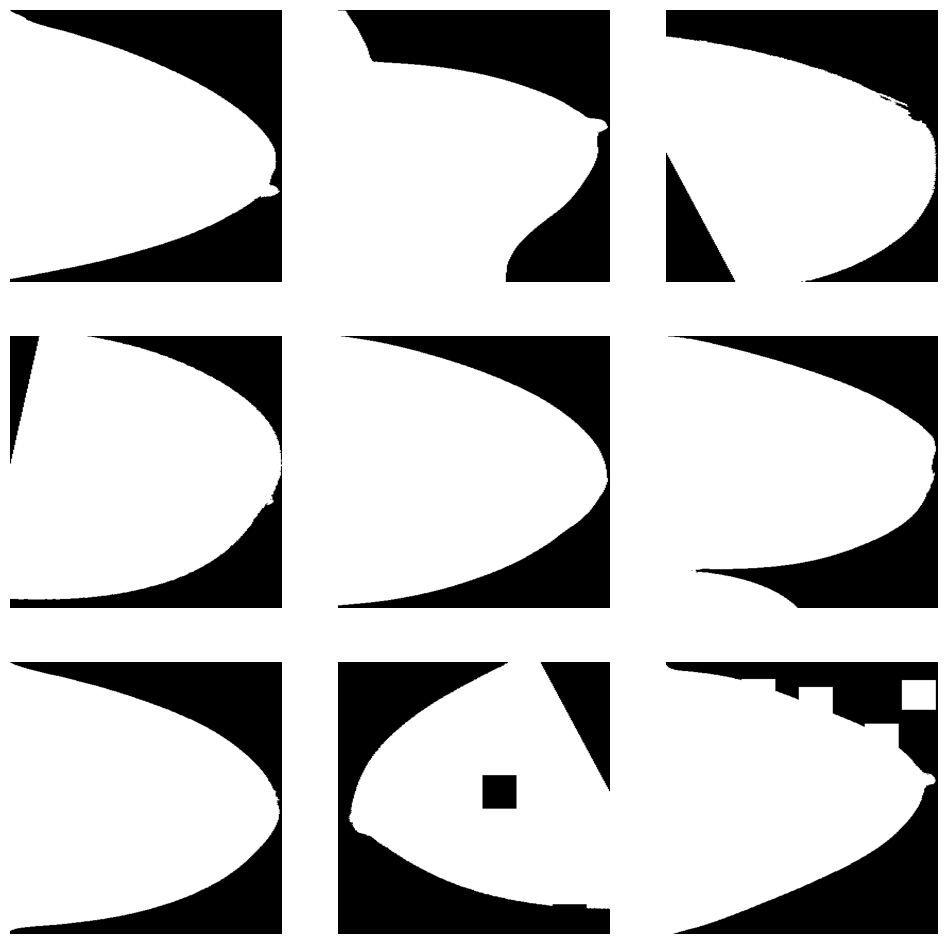

In [13]:
def plot_images(dataset):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    images, labels = next(dataset)
    axes = axes.ravel()
    for i in range(9):
      image = images[i]
      # print_img_props(image)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image, cmap='gray')
      plt.axis("off")
    
plot_images(train_generator)

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

model_convNext = ConvNeXtTiny(weights = 'imagenet', input_shape = (target_size[0], target_size[1], 3), include_top = False)

for layer in model_convNext.layers:
    layer.trainable = False
    
# build the entire model
x = model_convNext.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_convNext.input, outputs = predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 512, 512, 3)  0          ['input_2[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 128, 128, 96  4896       ['convnext_tiny_prestem_normaliza
 )                              )                                tion[0][0]']               

In [15]:
%load_ext tensorboard
from datetime import datetime

logs_dir = '/home/kasco/MDC/FinalProject/BreastCancerDetection/logs'

logdir = os.path.join(logs_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
from keras.optimizers import SGD, Adam

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'augmentation_convnext_v2.h5', monitor = "val_loss", mode = "min", save_best_only = True)

# define training function
def trainModel(model, epochs, optimizer, callbacks = []):
    batch_size = 48
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator,
                     validation_data=validation_generator,
                      epochs=epochs,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_steps = validation_generator.samples // batch_size,
                      batch_size=batch_size,
                      callbacks=callbacks)

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam =  Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_history = trainModel(model = model, epochs = 250, optimizer = adam, callbacks = [early_stopper, save_model, tensorboard_callback])

Epoch 1/250


2023-07-01 10:35:35.223487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


237/237 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.5006

2023-07-01 10:40:25.420784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


237/237 [==============================] - 364s 2s/step - loss: 0.8212 - accuracy: 0.5006 - val_loss: 0.6921 - val_accuracy: 0.5184
Epoch 2/250
237/237 [==============================] - 352s 1s/step - loss: 0.7757 - accuracy: 0.4989 - val_loss: 0.6909 - val_accuracy: 0.5332
Epoch 3/250
237/237 [==============================] - 351s 1s/step - loss: 0.7507 - accuracy: 0.5070 - val_loss: 0.6904 - val_accuracy: 0.5410
Epoch 4/250
237/237 [==============================] - 353s 1s/step - loss: 0.7430 - accuracy: 0.5037 - val_loss: 0.6899 - val_accuracy: 0.5452
Epoch 5/250
237/237 [==============================] - 354s 1s/step - loss: 0.7251 - accuracy: 0.5109 - val_loss: 0.6899 - val_accuracy: 0.5459
Epoch 6/250
237/237 [==============================] - 353s 1s/step - loss: 0.7201 - accuracy: 0.5086 - val_loss: 0.6899 - val_accuracy: 0.5353
Epoch 7/250
237/237 [==============================] - 350s 1s/step - loss: 0.7162 - accuracy: 0.5024 - val_loss: 0.6902 - val_accuracy: 0.5367
Epoc

In [17]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'loss')

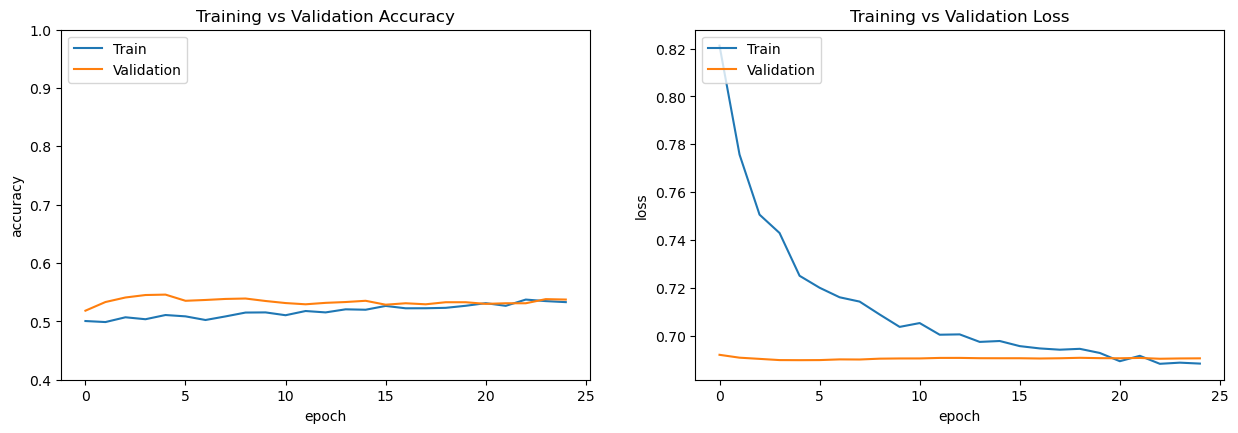

In [18]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

In [7]:
model_convNext =  load_model('augmentation_convnext_v2.h5')

pred_resnet50 = model_convNext.predict(test_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

ValueError: Unknown layer: 'LayerScale'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.